# Ridge Regression — End-to-End

This notebook builds on the linear regression pipeline and adds a Ridge Regression implementation with hyperparameter tuning (GridSearchCV). Assumes `retail_store_inventory.csv` is in the same directory as the notebook.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -------------------------
# Helper functions
# -------------------------
def smape(actual, forecast):
    """Symmetric Mean Absolute Percentage Error (avoids divide-by-zero)."""
    actual = np.array(actual, dtype=float)
    forecast = np.array(forecast, dtype=float)
    denom = (np.abs(actual) + np.abs(forecast))
    mask = denom == 0
    denom[mask] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(forecast - actual) / denom)

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"sMAPE: {smape_val:.4f}%")
    print(f"R²:   {r2:.4f}")
    return {'MAE': mae, 'RMSE': rmse, 'sMAPE': smape_val, 'R2': r2}


In [ ]:
# -------------------------
# Load dataset
# -------------------------
file_path = '/content/drive/MyDrive/data/retail_store_inventory.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path} - put 'retail_store_inventory.csv' in current directory")

df = pd.read_csv(file_path)
print("Loaded dataset shape:", df.shape)
display(df.head())

Loaded dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
# -------------------------
# Basic inspection & cleaning
# -------------------------
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Simple missing-value strategy: forward/backward fill (adjust as needed)
df = df.fillna(method='ffill').fillna(method='bfill')


Data types:
Date                   object
Store ID               object
Product ID             object
Category               object
Region                 object
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Demand Forecast       float64
Price                 float64
Discount                int64
Weather Condition      object
Holiday/Promotion       int64
Competitor Pricing    float64
Seasonality            object
dtype: object

Missing values per column:
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


/tmp/ipython-input-3082113766.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# -------------------------
# Feature engineering (date + simple)
# -------------------------
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    if df['Date'].isnull().any():
        df = df[df['Date'].notnull()].copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)

# Basic numeric sanity: ensure target exists
target_col = 'Units Sold'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")

# Drop identifiers that are not predictive (if present)
drop_cols = []
for c in ['Store ID', 'Product ID', 'Date']:
    if c in df.columns:
        drop_cols.append(c)
if drop_cols:
    df = df.drop(columns=drop_cols)

print('\nAfter feature engineering, shape:', df.shape)


After feature engineering, shape: (73100, 18)


In [ ]:
# -------------------------
# Encode categorical variables (one-hot)
# -------------------------
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nCategorical columns to encode:", cat_cols)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


Categorical columns to encode: ['Category', 'Region', 'Weather Condition', 'Seasonality']


In [ ]:
# -------------------------
# Train/test split
# -------------------------
X = df.drop(columns=[target_col])
y = df[target_col]

# Quick check: if any infinite or NaN values in X, drop those rows
mask_valid = np.isfinite(X.select_dtypes(include=[np.number])).all(axis=1)
if not mask_valid.all():
    X = X[mask_valid].copy()
    y = y[mask_valid].copy()

# For time-series tasks, consider chronological split; here we do a random split for demonstration
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (58480, 26) Test shape: (14620, 26)


In [ ]:
# -------------------------
# Scaling using StandardScaler inside a pipeline
# -------------------------
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric columns count:', len(numeric_cols))

# We'll build pipelines for Linear and Ridge so scaling is consistent.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_cols)], remainder='passthrough')

Numeric columns count: 13


In [ ]:
# -------------------------
# Baseline: Linear Regression pipeline
# -------------------------
linear_pipe = Pipeline([
    ('preproc', preprocessor),
    ('lr', LinearRegression())
])

linear_pipe.fit(X_train, y_train)
y_pred_lr = linear_pipe.predict(X_test)
print('\nLinear Regression performance:')
metrics_lr = print_metrics(y_test, y_pred_lr)


Linear Regression performance:
MAE:  7.4187
RMSE: 8.6018
sMAPE: 17.6400%
R²:   0.9938


In [ ]:
# -------------------------
# Ridge Regression with GridSearchCV (hyperparameter tuning)
# -------------------------
ridge_pipe = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

# Use TimeSeriesSplit if your data is chronological. Here we'll use 5-fold CV.
cv = 5
grid_ridge = GridSearchCV(ridge_pipe, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_ridge.fit(X_train, y_train)

print('\nBest Ridge params:', grid_ridge.best_params_)
print('Best CV score (neg MSE):', grid_ridge.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Ridge params: {'ridge__alpha': 1.0, 'ridge__solver': 'lsqr'}
Best CV score (neg MSE): -74.51266927264987


In [ ]:
# -------------------------
# Evaluate best Ridge model on test set
# -------------------------
best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

print('\nRidge Regression performance on test set:')
metrics_ridge = print_metrics(y_test, y_pred_ridge)

# Compare with Linear Regression
print('\nComparison:')
import pandas as pd
compare = pd.DataFrame([metrics_lr, metrics_ridge], index=['Linear', 'Ridge']).round(4)
display(compare)


Ridge Regression performance on test set:
MAE:  7.4186
RMSE: 8.6018
sMAPE: 17.6383%
R²:   0.9938

Comparison:


,MAE,RMSE,sMAPE,R2
Linear,7.4187,8.6018,17.6400,0.9938
Ridge,7.4186,8.6018,17.6383,0.9938


In [ ]:
# -------------------------
# Coefficients (Ridge) - mapping back to original feature names
# -------------------------
# Extract the trained Ridge step and the fitted scaler to map coefficients.
ridge_step = best_ridge.named_steps['ridge']
preproc = best_ridge.named_steps['preproc']

# To get feature order after ColumnTransformer + passthrough, we reconstruct:
# numeric_cols scaled, then remainder columns (which are passthrough non-numeric columns)
remainder_cols = [c for c in X_train.columns if c not in numeric_cols]
feature_names = numeric_cols + remainder_cols

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': ridge_step.coef_
})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False).reset_index(drop=True)
print('\nTop 15 Ridge features by absolute coefficient:')
display(coef_df.head(15)[['feature','coefficient']])


Top 15 Ridge features by absolute coefficient:


,feature,coefficient
0,Demand Forecast,108.297487
1,Inventory Level,0.511330
2,Region_South,-0.227600
3,Region_West,-0.174856
4,WeekOfYear,-0.159802
5,Region_North,-0.148013
6,Month,0.143023
7,Category_Groceries,0.123333
8,Category_Electronics,0.102872
9,Seasonality_Summer,-0.088284


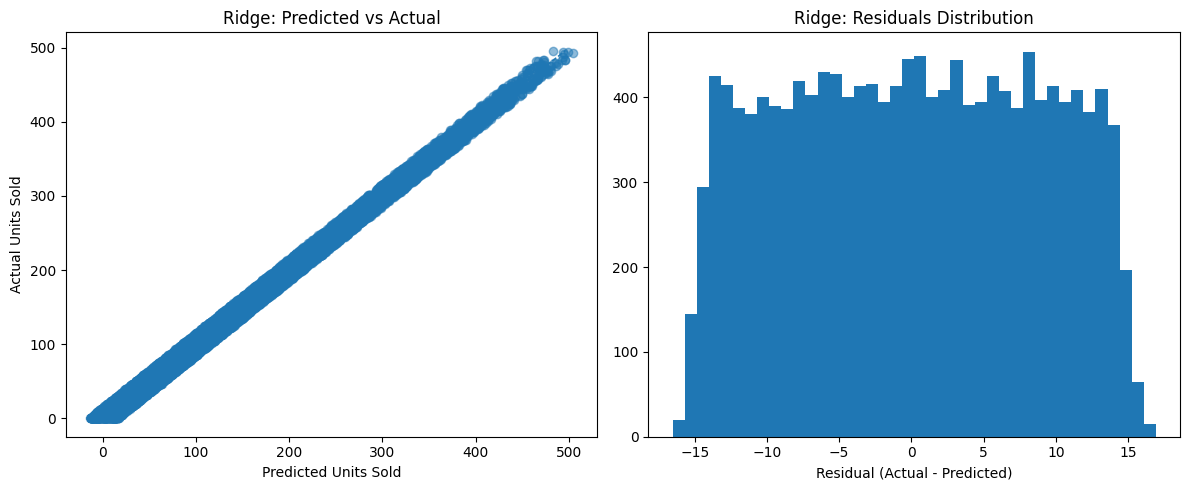

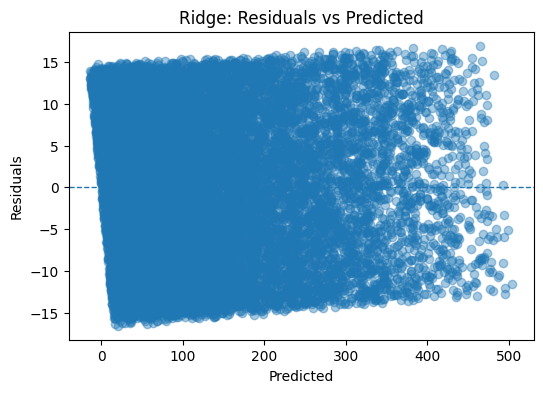

In [ ]:
# -------------------------
# Diagnostic plots for Ridge
# -------------------------
residuals_ridge = y_test - y_pred_ridge

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_pred_ridge, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=1)
plt.xlabel('Predicted Units Sold')
plt.ylabel('Actual Units Sold')
plt.title('Ridge: Predicted vs Actual')

plt.subplot(1,2,2)
plt.hist(residuals_ridge, bins=40)
plt.xlabel('Residual (Actual - Predicted)')
plt.title('Ridge: Residuals Distribution')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.4)
plt.axhline(0, linestyle='--', linewidth=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Ridge: Residuals vs Predicted')
plt.show()

In [ ]:
# -------------------------
# Save best Ridge model and preprocessor
# -------------------------
save_artifacts = True
if save_artifacts:
    joblib.dump(best_ridge, 'best_ridge_pipeline.joblib')
    print('\nSaved artifact: best_ridge_pipeline.joblib')


Saved artifact: best_ridge_pipeline.joblib


In [ ]:
# -------------------------
# Next suggestions
# -------------------------
print("\nNext suggestions:")
print("- If data is temporal, use TimeSeriesSplit and avoid shuffling.")
print("- Add lag/rolling features grouped by store/product to capture temporal dynamics.")
print("- Try ElasticNet or tree-based models for non-linear relationships.")
print("- Use permutation importance or SHAP for deeper interpretability.")


Next suggestions:
- If data is temporal, use TimeSeriesSplit and avoid shuffling.
- Add lag/rolling features grouped by store/product to capture temporal dynamics.
- Try ElasticNet or tree-based models for non-linear relationships.
- Use permutation importance or SHAP for deeper interpretability.
